In [109]:
import logging
import sys

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

In [110]:
import sys

import matplotlib.pyplot as plt

sys.path.append('../scripts')
sys.path.append('../')

from heapq import heappop, heappush
from itertools import count

import time
from multiprocessing import Pool
from time import sleep

import numpy as np
from tqdm.notebook import trange, tqdm
from scripts import centroids_graph_builder, graph_osm_loader, utils, clustering

import networkx as nx


In [111]:
def dijkstra_pfa_min_dst(graph: nx.Graph,
                 start: set[int],
                 ) -> \
        tuple[float, list[int]]:
    adjacency = graph._adj
    c = count()
    push = heappush
    pop = heappop
    dist = {}
    fringe = []
    for s in start:
        dist[s] = 0.0
        push(fringe, (0.0, next(c), s))
    while fringe:
        (d, _, v) = pop(fringe)
        for u, e in adjacency[v].items():
            vu_dist = d + e['length']
            if u not in dist or dist[u] > vu_dist:
                dist[u] = vu_dist
                push(fringe, (vu_dist, next(c), u))
    return dist


In [112]:
def get_rand_graph(N, p):
    G = nx.fast_gnp_random_graph(N, p, directed=False)
    if not nx.is_connected(G):
        tmp = []
        for n in nx.connected_components(G):
            for q in n:
                tmp.append(q)
                break
        for i in range(len(tmp) - 1):
            G.add_edge(tmp[i], tmp[i + 1])
    for e in G.edges:
        G.add_edge(e[0], e[1], length=np.random.random_sample() + 0.001)
    for u in G.nodes:
        if u in G[u]:
            G.remove_edge(u, u)
    return G

In [113]:
GRAPH_ID = 'R2555133'  # R13470549 R2555133 R3766483
# примеры id есть в graph_osm_loader.py
# g = get_rand_graph(1000, 0.1)  # загрузка графа
N = 100000
p = 3/N
# g = get_rand_grAaph(N,p)
# g = get_graph()
g= graph_osm_loader.get_graph(GRAPH_ID)
print(len(g.nodes), len(g.edges))

17931 27047


In [114]:
g.remove_edges_from(nx.selfloop_edges(g))

In [115]:
np.sqrt(len(g.nodes))

133.90668392578468

In [102]:
cms = clustering.resolve_k_means_communities(g, resolution=500, max_iteration=100, print_log=True)

2024-11-29 17:38:22,475 - root - INFO - communities: 3409


100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


### community

In [ ]:
import networkx as nx
import community  # python-louvain
import folium
import random
from collections import defaultdict

# Применяем алгоритм Лувена для поиска сообществ
partition = community.best_partition(g, weight='length')

# Группируем id по значению
grouped = defaultdict(set)
for id, value in partition.items():
    grouped[value].add(id)

# Преобразуем в список множеств
# cms = list(grouped.values())

# Генерация случайных цветов для сообществ
def generate_colors(n):
    return [f"#{random.randint(0, 0xFFFFFF):06x}" for _ in range(n)]

unique_communities = set(range(len(cms)))
colors = generate_colors(len(unique_communities))

# Создаем отображение цвета для каждого сообщества
community_colors = {community_id: color for community_id, color in zip(unique_communities, colors)}

# Создаем карту Folium
m = folium.Map()

# Отображаем узлы графа по сообществам
for community_id, community_nodes in enumerate(cms):
    color = colors[community_id]  # Цвет сообщества
    for node in community_nodes:
        node_data = g.nodes[node]
        folium.CircleMarker(
            location=(node_data['y'], node_data['x']),
            radius=7,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.8,
            popup=f"Node {node}, Community {community_id}"
        ).add_to(m)

m

In [10]:
d_clusters = np.zeros((len(cms), len(cms)),dtype=np.float32)
d_clusters.size * d_clusters.itemsize / 1024 / 1024

9.5367431640625e-05

In [118]:
from tqdm import tqdm
import numpy as np

def calc(data):
    points, name, cms, g = data 
    d_clusters = np.zeros((len(cms), len(cms)))

    # Добавляем tqdm для отслеживания обработки каждой вершины
    for u in tqdm(points, desc="Processing nodes"):
        ll = dijkstra_pfa_min_dst(g, cms[u])
        q = {}
        for v, d in ll.items():
            if g.nodes()[v][name] in q:
                q[g.nodes()[v][name]] = min(q[g.nodes()[v][name]], d)
            else:
                q[g.nodes()[v][name]] = d
        for v in range(len(cms)):
            if v in q:
                d_clusters[u, v] = q[v]
    
    return d_clusters


In [12]:
import numpy as np
import networkx as nx
from scipy.sparse.csgraph import shortest_path

def calc_fast(data):
    points, name, cms, g = data
    d_clusters = np.zeros((len(cms), len(cms)))

    # Преобразуем граф в матрицу смежности
    adj_matrix = nx.to_scipy_sparse_matrix(g, weight='length', format='csr')

    # Вычисляем кратчайшие пути между всеми узлами
    all_distances = shortest_path(csgraph=adj_matrix, directed=False)

    # Получаем группы узлов по их сообществам
    cluster_nodes = {i: [] for i in range(len(cms))}
    for node in g.nodes(data=True):
        cluster_id = node[1][name]  # Значение атрибута name
        cluster_nodes[cluster_id].append(node[0])

    # Для каждого узла в points считаем минимальное расстояние до всех кластеров
    for u in points:
        for cluster_id, nodes in cluster_nodes.items():
            d_clusters[u, cluster_id] = np.min(all_distances[u, nodes])

    return d_clusters

def calc_networkx(data):
    points, name, cms, g = data
    d_clusters = np.zeros((len(points), len(cms)))

    print("INFO: Начало предвычисления кратчайших расстояний между всеми парами узлов...")
    # Предвычисляем кратчайшие расстояния между всеми парами узлов
    all_distances = dict(tqdm(nx.all_pairs_dijkstra_path_length(g, weight='length'), 
                              total=len(g.nodes), 
                              desc="Вычисление кратчайших расстояний"))
    print("INFO: Кратчайшие расстояния рассчитаны.")

    print("INFO: Группировка узлов по сообществам...")
    # Группируем узлы по сообществам
    cluster_nodes = {i: [] for i in range(len(cms))}
    for node in tqdm(g.nodes(data=True), desc="Обработка узлов"):
        cluster_id = node[1][name]
        cluster_nodes[cluster_id].append(node[0])
    print("INFO: Узлы сгруппированы по сообществам.")

    print("INFO: Начало расчёта минимальных расстояний для узлов...")
    # Для каждого узла в points считаем минимальное расстояние до всех кластеров
    return d_clusters, cluster_nodes, all_distances, points
    for u in tqdm(points, desc="Обработка узлов points"):
        for cluster_id, nodes in cluster_nodes.items():
            d_clusters[u, cluster_id] = min(all_distances[u][v] for v in nodes)
    print("INFO: Расчёт минимальных расстояний завершён.")

    return d_clusters

In [162]:
lib_community = False

if lib_community:
    # Применяем алгоритм Лувена для поиска сообществ
    partition = community.best_partition(g)

    # Группируем id по значению
    grouped = defaultdict(set)
    for id, value in partition.items():
        grouped[value].add(id)

    # Преобразуем в список множеств
    cms = list(grouped.values())

else:
    cms = clustering.resolve_k_means_communities(g, resolution=100, max_iteration=100, print_log=True)



cms_points = list(range(len(cms)))
data = [cms_points,'cluster', cms, g]
d_clusters = calc(data)

2024-11-29 17:51:45,844 - root - INFO - communities: 1674
2024-11-29 17:51:45,844 - root - INFO - communities: 1674


Processing nodes: 100%|██████████| 1674/1674 [03:26<00:00,  8.10it/s]


In [170]:
import networkx as nx
import random
from collections import defaultdict
import numpy as np

def cluster_graph(g, method="louvain", **kwargs):
    """
    Кластеризация графа с выбором метода.

    :param g: Граф (networkx.Graph)
    :param method: Название метода кластеризации
    :param kwargs: Дополнительные параметры для методов
    :return: Список множеств узлов (cms)
    """
    if method == "louvain":
        import community  # python-louvain
        partition = community.best_partition(g)
        grouped = defaultdict(set)
        for node, cluster in partition.items():
            grouped[cluster].add(node)
            g.nodes[node]['cluster'] = cluster  # Добавляем атрибут 'cluster'
        cms = list(grouped.values())

    elif method == "girvan_newman":
        num_clusters = kwargs.get("num_clusters", 5)
        comp = nx.community.girvan_newman(g)
        for i, communities in enumerate(comp):
            if i + 1 == num_clusters:
                cms = [set(c) for c in communities]
                # Добавляем атрибут 'cluster' для каждого узла
                for idx, cluster in enumerate(communities):
                    for node in cluster:
                        g.nodes[node]['cluster'] = idx
                break

    elif method == "modularity":
        communities = nx.community.greedy_modularity_communities(g)
        cms = [set(c) for c in communities]
        # Добавляем атрибут 'cluster' для каждого узла
        for idx, community in enumerate(communities):
            for node in community:
                g.nodes[node]['cluster'] = idx

    elif method == "spectral":
        from sklearn.cluster import SpectralClustering
        n_clusters = kwargs.get("n_clusters", 5)
        adj_matrix = nx.to_numpy_array(g)
        spectral = SpectralClustering(n_clusters=n_clusters, affinity="precomputed", random_state=42)
        labels = spectral.fit_predict(adj_matrix)
        grouped = defaultdict(set)
        for node, label in zip(g.nodes(), labels):
            grouped[label].add(node)
            g.nodes[node]['cluster'] = label  # Добавляем атрибут 'cluster'
        cms = list(grouped.values())

    elif method == "walktrap":
        import igraph as ig
        ig_graph = ig.Graph.TupleList(g.edges(), directed=False)
        clusters = ig_graph.community_walktrap().as_clustering()
        cms = [set(cluster) for cluster in clusters]
        # Добавляем атрибут 'cluster' для каждого узла
        for idx, cluster in enumerate(clusters):
            for node in cluster:
                g.nodes[node]['cluster'] = idx

    elif method == "dbscan":
        from sklearn.cluster import DBSCAN
        positions = np.array([[g.nodes[node]['x'], g.nodes[node]['y']] for node in g.nodes()])
        eps = kwargs.get("eps", 0.5)
        min_samples = kwargs.get("min_samples", 5)
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(positions)
        grouped = defaultdict(set)
        for node, label in zip(g.nodes(), labels):
            if label != -1:  # -1 — шум
                grouped[label].add(node)
                g.nodes[node]['cluster'] = label  # Добавляем атрибут 'cluster'
        cms = list(grouped.values())

    elif method == "kmeans":
        from sklearn.cluster import KMeans
        positions = np.array([[g.nodes[node]['x'], g.nodes[node]['y']] for node in g.nodes()])
        n_clusters = kwargs.get("n_clusters", 5)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(positions)
        grouped = defaultdict(set)
        for node, label in zip(g.nodes(), labels):
            grouped[label].add(node)
            g.nodes[node]['cluster'] = label  # Добавляем атрибут 'cluster'
        cms = list(grouped.values())

    elif method == "connected_components":
        components = nx.connected_components(g)
        cms = [set(component) for component in components]
        # Добавляем атрибут 'cluster' для каждого узла
        for idx, component in enumerate(components):
            for node in component:
                g.nodes[node]['cluster'] = idx

    elif method == "random":
        num_clusters = kwargs.get("num_clusters", 5)
        nodes = list(g.nodes())
        random.shuffle(nodes)
        cms = [set(nodes[i::num_clusters]) for i in range(num_clusters)]
        # Добавляем атрибут 'cluster' для каждого узла
        for idx, cluster in enumerate(cms):
            for node in cluster:
                g.nodes[node]['cluster'] = idx

    # elif method == "sbm":
    #     import graph_tool.all as gt
    #     gt_graph = gt.Graph(directed=False)
    #     gt_graph.add_edge_list(g.edges())
    #     state = gt.minimize_blockmodel_dl(gt_graph)
    #     blocks = state.get_blocks()
    #     grouped = defaultdict(set)
    #     for node in range(len(blocks)):
    #         grouped[blocks[node]].add(node)
    #         g.nodes[node]['cluster'] = blocks[node]  # Добавляем атрибут 'cluster'
    #     cms = list(grouped.values())

    else:
        raise ValueError(f"Unknown clustering method: {method}")

    return cms


In [173]:
cms = cluster_graph(g, method="louvain")
cms_points = list(range(len(cms)))
data = [cms_points,'cluster', cms, g]
d_clusters = calc(data)

Processing nodes: 100%|██████████| 70/70 [00:07<00:00,  9.22it/s]


In [174]:
import pandas as pd
pd.DataFrame(d_clusters)

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,0.000,10568.395,18736.841,20815.566,8418.655,12130.133,19354.646,11723.082,18143.905,27890.285,...,21420.912,2795.445,28984.331,8701.166,36064.729,1696.990,12873.033,35221.827,27009.672,23603.314
1,10568.395,0.000,20770.632,19887.137,14997.307,18388.165,6239.531,258.869,17790.626,24046.049,...,13294.344,19925.826,15866.115,18413.025,31835.805,15220.820,18714.464,30992.903,26534.275,13707.315
2,18736.841,20770.632,0.000,56.185,2504.981,184.528,20823.056,21973.049,15.843,5378.618,...,19769.724,8923.907,30257.108,8384.209,15661.734,26067.266,8820.468,18106.462,1454.698,22182.930
3,20815.566,19887.137,56.185,0.000,7914.059,4552.199,18522.467,20952.183,350.150,382.885,...,13838.773,15005.087,26946.397,14330.176,9992.874,27680.163,14229.546,12437.602,402.160,16778.888
4,8418.655,14997.307,2504.981,7914.059,0.000,155.720,17458.767,16685.281,3530.721,14773.056,...,18019.597,174.962,26897.219,41.803,25590.222,15749.080,212.550,28034.950,11288.967,20260.767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,12873.033,18714.464,8820.468,14229.546,212.550,4478.812,21112.372,20402.438,9846.208,21088.543,...,21673.202,7833.761,30550.824,3639.007,31905.709,20203.458,0.000,33091.048,17604.454,23914.372
66,35221.827,30992.903,18106.462,12437.602,28034.950,24376.100,27598.608,29926.251,20665.982,7006.689,...,15589.471,33115.479,30459.413,32974.757,2406.449,42083.638,33091.048,0.000,17875.510,18529.586
67,27009.672,26534.275,1454.698,402.160,11288.967,7724.336,25513.756,27625.906,4212.095,5466.511,...,20814.432,16463.715,34309.423,16087.651,15430.782,34336.027,17604.454,17875.510,0.000,23754.547
68,23603.314,13707.315,22182.930,16778.888,20260.767,20929.054,8545.207,11088.577,18858.500,16285.699,...,85.880,26832.501,10700.685,25261.791,19510.381,30453.086,23914.372,18529.586,23754.547,0.000


In [175]:
nodes = g.nodes()

In [176]:
def func(u, v):
    n1,n2 = nodes[u],nodes[v]
    c11 = n1['cluster']
    c12 = n2['cluster']  
    return d_clusters[c11, c12]

In [177]:
def dijkstra_pfa_cls(graph: nx.Graph,
                     start: int,
                     end: int
                     ) -> tuple[float, list[int]]:
    if start == end:
        return 0, [start]
    push = heappush
    pop = heappop
    dist = {start: (0, None)}
    fringe = []
    c = count()
    adjacency = graph._adj
    print()
    push(fringe, (0, next(c), 0, func(start, end), start))

    while fringe:
        (_, _, d1, l1, v1) = pop(fringe) 
        if v1 == end:
            break
        for u, e in adjacency[v1].items():
            vu_dist = d1 + e['length']
            if u not in dist or dist[u][0] > vu_dist:
                dist[u] = (vu_dist, v1)
                lu = func(u, end)
                push(fringe, (vu_dist + lu, next(c), vu_dist, lu, u))
    path = [end]
    e = end
    while dist[e][1] is not None:
        e = dist[e][1]
        path.append(e)
    l = 0
    e = g.edges()
    for i in range(len(path) - 1):
        p1, p2 = path[i], path[i + 1]
        l += e[p1, p2]['length']
    path.reverse()
    return l, path

In [178]:
def bi_dijkstra_pfa_cls(graph: nx.Graph,
                        start: int,
                        end: int
                        ) -> tuple[float, list[int]]:
    if start == end:
        return 0, [start]
    
    push = heappush
    pop = heappop
    dist = ({start: (0, None)}, {end: (0, None)})
    fringe = ([], [])
    c = count()
    adjacency = graph._adj

    push(fringe[0], (0, next(c), 0,  start))
    push(fringe[1], (0, next(c), 0,  end))
    
    union_node = None
    union_dst = float('inf')
    seen = (set(), set())
    while fringe[0] and fringe[1]:
        (_, _, d1,  v1) = pop(fringe[0])
        (_, _, d2,  v2) = pop(fringe[1])

        for u, e in adjacency[v1].items():
            vu_dist = d1 + e['length']
            if u not in dist[0] or dist[0][u][0] > vu_dist:
                dist[0][u] = (vu_dist, v1)
                lu = func(u,end)
                push(fringe[0], (vu_dist + lu, next(c), vu_dist, u))
        for u, e in adjacency[v2].items():
            vu_dist = d2 + e['length']
            if u not in dist[1] or dist[1][u][0] > vu_dist:
                dist[1][u] = (vu_dist, v2)
                lu = func(u,start)
                push(fringe[1], (vu_dist + lu, next(c), vu_dist, u))
        if v1 in seen[1]:
            union_node = v1
            union_dst = dist[0][v1][0] + dist[1][v1][0]
            break
        if v2 in seen[0]:
            union_node = v2
            union_dst = dist[0][v2][0] + dist[1][v2][0]
            break
        seen[0].add(v1)
        seen[1].add(v2)
        
    for (_, _, d1, v1) in fringe[0]:
        if v1 in dist[1]:
            dd = dist[1][v1][0] + dist[0][v1][0]
            if dd < union_dst:
                union_dst = dd
                union_node = v1
        for u, e in adjacency[v1].items():
            if u in dist[1]:
                if u not in dist[0]:
                    vu_dist = d1 + e['length']
                    dist[0][u] = (vu_dist, v1)    
                dd = dist[1][u][0] + dist[0][u][0]
                if dd < union_dst:
                    union_dst = dd
                    union_node = u
                    
    for (_, _, d2, v2) in  fringe[1]:
        if v2 in dist[0]:
            dd = dist[1][v2][0] + dist[0][v2][0]
            if dd < union_dst:
                union_dst = dd
                union_node = v2
        for u, e in adjacency[v2].items():
            if u in dist[0]:
                if u not in dist[1]:
                    vu_dist = d2 + e['length']
                    dist[1][u] = (vu_dist, v2)
                dd = dist[1][u][0] + dist[0][u][0]
                if dd < union_dst:
                    union_dst = dd
                    union_node = u
    path = []
    e = union_node
    while dist[0][e][1] is not None:
        path = [e] + path
        e = dist[0][e][1]
    path = [e] + path

    e = union_node
    while dist[1][e][1] is not None:
        e = dist[1][e][1]
        path += [e]

    l = 0
    e = g.edges()
    for i in range(len(path) - 1):
        p1, p2 = path[i], path[i + 1]
        l += e[p1, p2]['length']
    return l, path

In [179]:
points = [utils.get_node_for_initial_graph_v2(g) for _ in trange(1000, desc='generate points')]

generate points:   0%|          | 0/1000 [00:00<?, ?it/s]

In [180]:
NUM_ITERATION = 3  # чтобы уменьшить ошибку при вычислении времени выполнения, при каждом замере время меряется для NUM_ITERATION повторений
WORKER = 1  # количество потоков


def do_calc(data):
    pps, worker_id = data

    stat = {
        'l': [],
        'h_l': [],
        'p': [],
        'h_p': [],
        'time_l': [],
        'time_h': [],
        'delta': [],
    }

    # Чтобы `tqdm` корректно отображался для каждого WORKER
    sleep(worker_id / 10)
    print(f"INFO: Worker {worker_id} started")

    for p1, p2 in tqdm(pps, desc=f'Worker {worker_id} - find paths', position=worker_id):
        if (p1, p2) in stat:
            continue

        # Классический алгоритм Дейкстры
        l, p = None, None
        start = time.time()
        for _ in range(NUM_ITERATION):
            l, p = nx.single_source_dijkstra(g, p1, p2, weight='length')
        time_l = (time.time() - start) / NUM_ITERATION

        # Иерархический алгоритм
        h_l, h_p = None, None
        start = time.time()
        for _ in range(NUM_ITERATION):
            h_l, h_p = dijkstra_pfa_cls(g, p1, p2)
        time_h = (time.time() - start) / NUM_ITERATION

        # Вычисление относительной ошибки
        delta = (h_l - l) / l * 100 if l != 0 else 0

        # Сохранение результатов
        stat['l'].append(l)
        stat['h_l'].append(h_l)
        stat['p'].append(p)
        stat['h_p'].append(h_p)
        stat['delta'].append(delta)
        stat['time_l'].append(time_l)
        stat['time_h'].append(time_h)

    return stat

In [181]:
WORKER = 1
data_2 = [(points, 1)]

# Обработка данных
results = []
for worker_data in data_2:
    results.append(do_calc(worker_data))

# Слияние результатов
stat = {
    'l': [],
    'h_l': [],
    'p': [],
    'h_p': [],
    'time_l': [],
    'time_h': [],
    'delta': [],
}

for worker_stat in results:
    for key in stat:
        stat[key].extend(worker_stat[key])

# Вывод результатов
print(f"err_mean: {np.mean(stat['delta']):.2f} %")
print(f"err_min: {np.min(stat['delta']):.2f} %")
print(f"err_max: {np.max(stat['delta']):.2f} %")
print(f"acceleration: {np.mean(np.array(stat['time_l']) / np.array(stat['time_h'])):.2f} times")

Worker 1 - find paths:  13%|█▎        | 127/1000 [00:55<07:36,  1.91it/s]

Worker 1 - find paths:  15%|█▍        | 147/1000 [01:02<03:28,  4.09it/s]

Worker 1 - find paths:  18%|█▊        | 183/1000 [01:13<05:34,  2.45it/s]


Worker 1 - find paths:  18%|█▊        | 185/1000 [01:14<05:46,  2.35it/s]

Worker 1 - find paths:  21%|██        | 208/1000 [01:21<03:34,  3.70it/s]

Worker 1 - find paths:  22%|██▏       | 223/1000 [01:27<03:04,  4.21it/s]

Worker 1 - find paths:  23%|██▎       | 233/1000 [01:32<08:10,  1.56it/s]

Worker 1 - find paths:  24%|██▎       | 236/1000 [01:34<08:20,  1.53it/s]

Worker 1 - find paths:  24%|██▍       | 243/1000 [01:36<05:45,  2.19it/s]

Worker 1 - find paths:  31%|███       | 311/1000 [01:58<03:17,  3.50it/s]

Worker 1 - find paths:  32%|███▏      | 322/1000 [02:02<03:46,  3.00it/s]

Worker 1 - find paths:  35%|███▍      | 346/1000 [02:10<03:37,  3.01it/s]

Worker 1 - find paths:  35%|███▍      | 349/1000 [02:11<03:28,  3.12it/s]

Worker 1 - find paths:  38%|███▊      | 380/1000 [02:26<08:21,  1.24it/s]

Worker 1 - find paths:  39%|███▊      | 386/1000 [02:28<03:39,  2.79it/s]

Worker 1 - find paths:  41%|████      | 412/1000 [02:38<03:20,  2.94it/s]

Worker 1 - find paths:  44%|████▍     | 440/1000 [02:47<02:55,  3.20it/s]


Worker 1 - find paths:  44%|████▍     | 441/1000 [02:48<03:29,  2.67it/s]

Worker 1 - find paths:  44%|████▍     | 443/1000 [02:49<03:33,  2.61it/s]

Worker 1 - find paths:  45%|████▌     | 450/1000 [02:52<05:06,  1.80it/s]


Worker 1 - find paths:  45%|████▌     | 452/1000 [02:52<03:22,  2.70it/s]

Worker 1 - find paths:  46%|████▌     | 461/1000 [02:56<04:47,  1.88it/s]

Worker 1 - find paths:  48%|████▊     | 479/1000 [03:03<02:41,  3.22it/s]


Worker 1 - find paths:  49%|████▊     | 486/1000 [03:05<02:30,  3.42it/s]

Worker 1 - find paths:  50%|█████     | 500/1000 [03:11<03:38,  2.28it/s]

Worker 1 - find paths:  52%|█████▏    | 519/1000 [03:19<02:59,  2.68it/s]

Worker 1 - find paths:  52%|█████▏    | 523/1000 [03:20<02:37,  3.02it/s]

Worker 1 - find paths:  54%|█████▎    | 535/1000 [03:25<03:48,  2.03it/s]

Worker 1 - find paths:  54%|█████▍    | 538/1000 [03:26<02:34,  2.99it/s]

Worker 1 - find paths:  56%|█████▋    | 563/1000 [03:36<03:30,  2.07it/s]

Worker 1 - find paths:  60%|█████▉    | 598/1000 [03:46<01:21,  4.92it/s]

Worker 1 - find paths:  62%|██████▏   | 620/1000 [03:53<01:35,  3.97it/s]


Worker 1 - find paths:  63%|██████▎   | 626/1000 [03:54<01:49,  3.42it/s]

Worker 1 - find paths:  64%|██████▎   | 635/1000 [03:58<03:34,  1.70it/s]

Worker 1 - find paths:  65%|██████▍   | 649/1000 [04:04<01:58,  2.96it/s]

Worker 1 - find paths:  66%|██████▌   | 655/1000 [04:06<01:37,  3.55it/s]

Worker 1 - find paths:  68%|██████▊   | 676/1000 [04:15<02:04,  2.59it/s]

Worker 1 - find paths:  71%|███████   | 707/1000 [04:25<00:45,  6.45it/s]

Worker 1 - find paths:  72%|███████▎  | 725/1000 [04:31<01:37,  2.82it/s]

Worker 1 - find paths:  74%|███████▎  | 737/1000 [04:37<01:34,  2.78it/s]

Worker 1 - find paths:  74%|███████▍  | 744/1000 [04:39<01:18,  3.26it/s]


Worker 1 - find paths:  74%|███████▍  | 745/1000 [04:39<01:26,  2.96it/s]

Worker 1 - find paths:  75%|███████▍  | 747/1000 [04:40<01:17,  3.27it/s]

Worker 1 - find paths:  78%|███████▊  | 777/1000 [04:50<01:02,  3.57it/s]

Worker 1 - find paths:  79%|███████▊  | 786/1000 [04:54<01:26,  2.47it/s]

Worker 1 - find paths:  82%|████████▏ | 819/1000 [05:08<01:33,  1.93it/s]

Worker 1 - find paths:  82%|████████▎ | 825/1000 [05:10<00:51,  3.37it/s]

Worker 1 - find paths:  84%|████████▍ | 842/1000 [05:16<00:43,  3.65it/s]

Worker 1 - find paths:  88%|████████▊ | 875/1000 [05:28<00:56,  2.21it/s]

Worker 1 - find paths:  88%|████████▊ | 884/1000 [05:31<00:31,  3.72it/s]

Worker 1 - find paths:  91%|█████████▏| 913/1000 [05:37<00:28,  3.05it/s]

Worker 1 - find paths:  93%|█████████▎| 927/1000 [05:42<00:24,  3.00it/s]

Worker 1 - find paths:  94%|█████████▍| 940/1000 [05:47<00:16,  3.61it/s]

Worker 1 - find paths:  94%|█████████▍| 942/1000 [05:49<00:26,  2.16it/s]

Worker 1 - find paths: 100%|██████████| 1000/1000 [06:08<00:00,  2.72it/s]




err_mean: 1.05 %
err_min: -0.00 %
err_max: 103.31 %
acceleration: nan times



E:\Temp\ipykernel_15752\3251055789.py:28: RuntimeWarning: divide by zero encountered in divide
  print(f"acceleration: {np.mean(np.array(stat['time_l']) / np.array(stat['time_h'])):.2f} times")
E:\Temp\ipykernel_15752\3251055789.py:28: RuntimeWarning: invalid value encountered in divide
  print(f"acceleration: {np.mean(np.array(stat['time_l']) / np.array(stat['time_h'])):.2f} times")


In [182]:
max_err_idx = np.argmax(stat['delta'])

In [183]:
path = stat['p'][max_err_idx]
h_path = stat['h_p'][max_err_idx]

In [184]:
len(path), len(h_path)

(44, 62)

In [185]:
stat['l'][max_err_idx], stat['h_l'][max_err_idx]

(10344.764999999998, 21032.405000000006)

In [186]:
p1, p2 = path[0], path[-1]

In [187]:
labels = {u: d['cluster'] for u, d in g.nodes(data=True)}

In [188]:
pos_l = {u: [d['x'] + 0.001, d['y'] + 0.001] for u, d in g.nodes(data=True)}
pos = {u: [d['x'], d['y']] for u, d in g.nodes(data=True)}

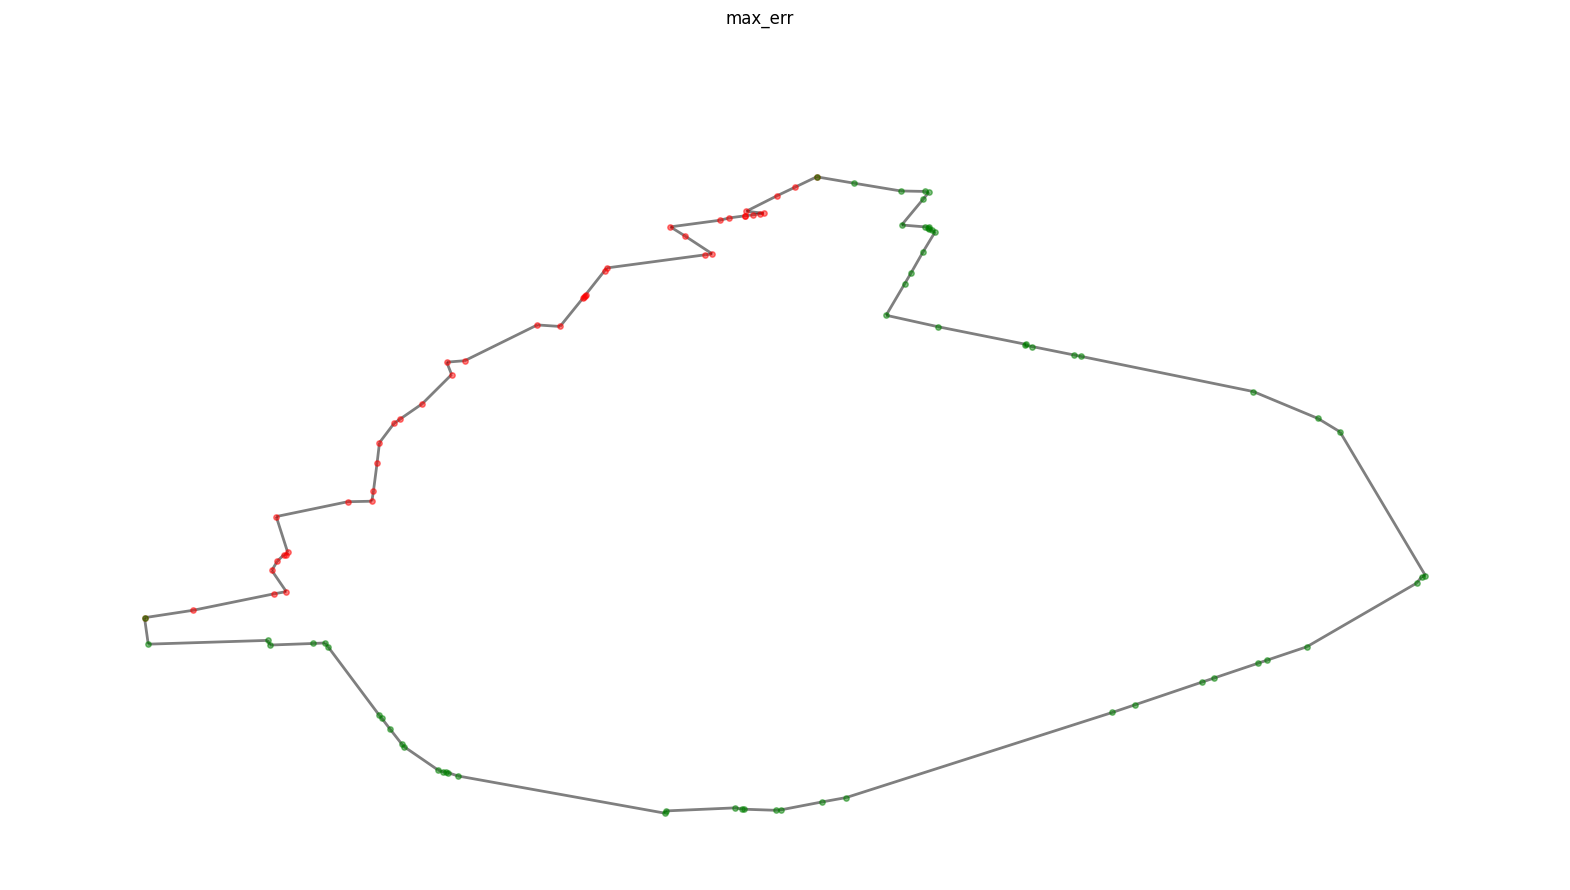

In [189]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
f.suptitle('max_err')


# nx.draw(g, pos=pos, ax=ax, node_size=10, alpha=0.5)
nx.draw(g.subgraph(path), pos=pos, ax=ax, node_size=15, node_color='red', width=2, alpha=0.5)
nx.draw(g.subgraph(h_path), pos=pos, ax=ax, node_size=15, node_color='green', width=2, alpha=0.5)
# nx.draw_networkx_labels(g,pos_l,labels=labels,font_size=6)

In [ ]:
nx.single_source_dijkstra(g,p1,p2,weight='length')

In [ ]:
bi_dijkstra_pfa_cls(g, p1,p2)

In [64]:
893305603 in nx.single_source_dijkstra(g,p1,p2,weight='length')[1]

False